In [322]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [323]:
# Set model parameters
epochs = 325
reg_param = 0.001
add_sparsity = True
learning_rate = 1e-4
batch_size = 128

Add sparsity regularization: True


In [324]:
# Set training and testing set periods
train_start_index = "2018-01-01"
train_end_index = '2019-12-31'

test_start_index = '2021-05-01'
test_end_index = '2021-07-01'

# Get number of months between two dates / Make sure to give end dates in format Year-Month-31/30 not Year-Month-01
def months_between_date(start_date, end_date):
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    return ((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)+1)


# Extract subsets from components and index datasets
def extract_set(start_date, end_date):
    # load data 
    constituents_returns = pd.read_csv("../data/finalized_ftse_all_comps_pc_returns_2014-JUL2021.csv", index_col='Date', parse_dates=True)
    idx_returns = pd.read_csv("../data/ftse_index_returns_2014-JUL2021.csv", index_col='Date', parse_dates=True)
    period_stocks = pd.read_csv("../data/2014-2021_reconstructed_constituents_with_symbols.csv", index_col='Date', parse_dates=True)
    # Get constituents of the index during the wanted period
    period_stocks = period_stocks.loc[start_date:end_date].dropna(axis=0, how='any')
    # Get stock symbols that are present in the index during the totality of the desired period
    f = months_between_date(start_date, end_date)
    freq = period_stocks[['Symbol']].value_counts()
    symbols = freq.loc[freq==f].reset_index()['Symbol']
    # Get stock symbols that were constituents of the index during the wanted period
    to_remove = np.setdiff1d(symbols, constituents_returns.columns)
    period_symbols = []
    # remove any stock symbols that do not appear in the daily returns dataset
    if(len(to_remove)>0):
        period_symbols = [elem for elem in symbols if elem not in to_remove]
    else:
        period_symbols = symbols

    # Extract daily percentage changes/returns for the desired period
    period_comp_returns = constituents_returns[period_symbols].loc[start_date:end_date].dropna(axis=1, how='any')

    period_idx_returns = idx_returns.loc[start_date:end_date]
    #
    return period_comp_returns.iloc[:,:84], period_idx_returns.iloc[:,:84]




In [325]:
# Implementing a Dataloader to load our custom stocks and index datasets:
class ReturnsLoader(Dataset):
    def __init__(self, start_date, end_date, transform=None):
        self.features, self.labels = extract_set(start_date, end_date) 
        self.length = len(self.features)
        self.transform = transform
        
    def __getItem__(self, index):
        features = self.features.loc[index].values
        labels = self.labels.loc[index].values
        if self.transform:
            features = self.transform(features.to_numpy())
            labels = self.transform(labels.to_numpy())
        return torch.tensor(features), torch.tensor(labels)
    
    def __len__(self):
        return self.length

In [326]:
# training set norm values
train_f, _ = extract_set(train_start_index, train_end_index)
train_mean = train_f.mean() 
train_std = train_f.std()

# Test set norm values
test_f, _ = extract_set(test_start_index, test_end_index)
test_mean = test_f.mean() 
test_std = test_f.std()

# Transforms - Normalization
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([train_mean], [train_std])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([test_mean], [test_std])
])
# Load datasets
train_set = ReturnsLoader(train_start_index, train_end_index)#, transform = train_transform)
test_set = ReturnsLoader(test_start_index, test_end_index)#, transform = test_transform)

#manual normalization
from sklearn.preprocessing import StandardScaler
#normalize training set
tr_set = train_set.features
tr_scaler = StandardScaler()
tr_set.iloc[:,0:] = tr_scaler.fit_transform(tr_set.iloc[:,0:])

#normalize testing set
tst_set = test_set.features
tst_scaler = StandardScaler()
tst_set.iloc[:,0:] = tst_scaler.fit_transform(tst_set.iloc[:,0:])

# trainloader
trainloader = DataLoader(
    tr_set.to_numpy(), 
    batch_size=batch_size,
    shuffle=False
)
#testloader
testloader = DataLoader(
    tst_set.to_numpy(), 
    batch_size=batch_size, 
    shuffle=False
)
# print(len(test_f))

Before mean: AAL      0.086364
MRW     -0.012095
RIO      0.039526
REL      0.025336
RDSa    -0.012905
           ...   
HLMA     0.111818
FLTRF    0.026561
FERG     0.049585
HRGV     0.030711
HSBA    -0.045079
Length: 84, dtype: float64
Before mean: AAL    -0.116667
RMV     0.171905
RIO    -0.040238
REL     0.111905
RDSa    0.221905
          ...   
ICAG   -0.238571
HSBA   -0.153333
HRGV   -0.162381
HLMA    0.117857
HIK     0.103333
Length: 84, dtype: float64


In [328]:
# get the computation device
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()
# make the `images` directory
def make_dir():
    image_dir = '../outputs/images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
# make_dir()
# for saving the reconstructed images
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

In [329]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, n_inputs):
        super(SparseAutoencoder, self).__init__()
        self.in_out = n_inputs
 
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.in_out, out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=16),
            nn.Tanh(),
            nn.Linear(in_features=16, out_features=4),
            nn.Tanh(),
            nn.Linear(in_features=4, out_features=2),
            nn.Tanh(),
            nn.Linear(in_features=2, out_features=1),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=1, out_features=2),
            nn.Tanh(),
            nn.Linear(in_features=2, out_features=4),
            nn.Tanh(),
            nn.Linear(in_features=4, out_features=16),
            nn.Tanh(),
            nn.Linear(in_features=16, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=self.in_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
#instantiate autoencoder
n_inputs = len(train_set.features.columns)
model = SparseAutoencoder(n_inputs).to(device)

In [330]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [331]:
# get the layers as a list
model_children = list(model.children())
for i in range (len(model_children)):
    print(model_children[i])

Sequential(
  (0): Linear(in_features=84, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=4, bias=True)
  (7): Tanh()
  (8): Linear(in_features=4, out_features=2, bias=True)
  (9): Tanh()
  (10): Linear(in_features=2, out_features=1, bias=True)
  (11): Tanh()
)
Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=4, bias=True)
  (3): Tanh()
  (4): Linear(in_features=4, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=64, bias=True)
  (9): Tanh()
  (10): Linear(in_features=64, out_features=84, bias=True)
  (11): Tanh()
)


In [332]:
# define the sparse loss function
def sparse_loss(autoencoder, daily_changes):
    loss = 0
    values = daily_changes
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))  
        loss += torch.mean(torch.abs(values))
    return loss

In [333]:
def calculate_cc(mat1, mat2):
    """Compute Pearson correlation coefficient"""
    # Compute correlation matrix
    corr_matrix = np.corrcoef(mat1, mat2)
    # Return entry [0,1]
    return corr_matrix[0,1]

def select_top_assets(model, dataset, k):
    '''select the assets with K largest correlation coefficient with middle node (w)'''
    w = []
    ccs = pd.DataFrame({"Company":[], "CC":[]})
    for i in range(len(dataset)):
        encoded = model.encoder(torch.tensor(dataset.iloc[i,:]).float())
        output = encoded.detach().cpu().numpy().flatten()
        w.append(output[0])
    for i in range(len(dataset.columns)):
        cc = calculate_cc(w, dataset.iloc[:,i].to_numpy().flatten())
        ccs = ccs.append({"Company":dataset.columns[i],"CC":abs(cc)}, ignore_index=True)

    # select the assets with K largest correlation coefficient
    return ccs.sort_values(by='CC', ascending=False).iloc[:k,:]  

In [334]:
# define the training function
def fit(model, dataloader, epoch):
    print('Training')
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_set.features)/dataloader.batch_size)):
        counter += 1
        daily_changes = data
        daily_changes = daily_changes.to(device)
        
        optimizer.zero_grad()
        outputs = model(daily_changes.float())
        mse_loss = criterion(outputs, daily_changes.float())
        if add_sparsity == True:
            l1_loss = sparse_loss(model, daily_changes.float())
            # add the sparsity penalty
            loss = mse_loss + reg_param * l1_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / counter
    print(f"Train Loss: {loss:.3f}")
    # save the reconstructed images every 5 epochs
    if epoch % 5 == 0:
        print("Current epoch: ", epoch)
    return epoch_loss

In [335]:
# define the validation function
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(test_set.features)/dataloader.batch_size)):            
            counter += 1
            daily_changes = data
            daily_changes = daily_changes.to(device)
            outputs = model(daily_changes.float())
            loss = criterion(outputs, daily_changes.float())
            running_loss += loss.item()
    epoch_loss = running_loss / counter
    print(f"Val Loss: {loss:.3f}")  
    # 
    if epoch % 5 == 0:
        print("Validation epoch: ", epoch) 
    return epoch_loss

In [336]:
# train and validate the autoencoder neural network
train_loss = []
val_loss = []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, testloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model
torch.save(model.state_dict(), f"../outputs/sparse_ae_epochs_{epochs}_batchsize_{batch_size}_norm.pth")

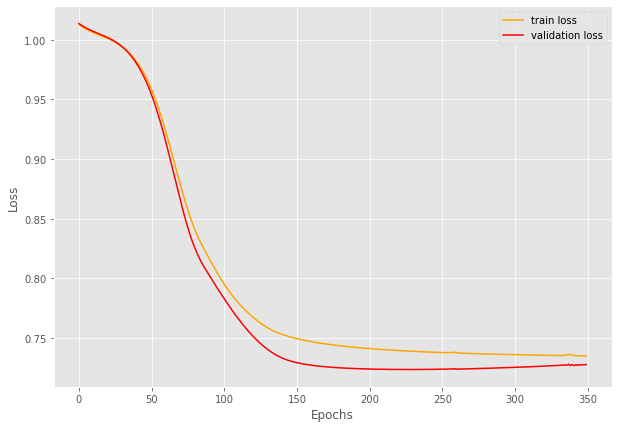

In [337]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"../outputs/loss_{train_start_index}_{train_end_index}_{epochs}epochs_{batch_size}batch_size.png")
plt.show()

In [338]:
# revert scaling done on the datasets
tr_set.iloc[:,0:] = tr_scaler.inverse_transform(tr_set)

tst_set.iloc[:,0:] = tst_scaler.inverse_transform(tst_set)



revert mean: AAL      0.086364
MRW     -0.012095
RIO      0.039526
REL      0.025336
RDSa    -0.012905
           ...   
HLMA     0.111818
FLTRF    0.026561
FERG     0.049585
HRGV     0.030711
HSBA    -0.045079
Length: 84, dtype: float64
revert mean: AAL    -0.116667
RMV     0.171905
RIO    -0.040238
REL     0.111905
RDSa    0.221905
          ...   
ICAG   -0.238571
HSBA   -0.153333
HRGV   -0.162381
HLMA    0.117857
HIK     0.103333
Length: 84, dtype: float64


In [339]:
#load model and compute correlation coefficient for every Xi (stock in the index) with the middle 1 node layer latent representation
saved_model = SparseAutoencoder(n_inputs)
saved_model.load_state_dict(torch.load("../outputs/sparse_ae_epochs_350_batchsize_128_norm.pth"))
# Tracking portfolio asset selection
k = 50
top_train_assets = select_top_assets(saved_model, tr_set, k)
top_test_assets = select_top_assets(saved_model, tst_set, k)
# Display
display(top_test_assets.head())

,Company,CC
27,WPP,0.805552
15,MRON,0.805470
8,PRU,0.775043
40,SMIN,0.773609
41,SMDS,0.770931
28,WEIR,0.767745
75,WTB,0.751551
32,TW,0.746066
78,ICP,0.740026
16,MNDI,0.735808


In [340]:
# Tracking the index with equal weights assignment
def compute_tracking_porfolio_cum_return(dataset, selected_assets):
    n_assets = len(selected_assets)
#     rows = len(dataset)
    # make matrix of equal weights
    weights = [1/n_assets for i in range(n_assets)]
    #
    selected_assets_returns = dataset[selected_assets['Company']].iloc[::-1]

    weighted_daily_returns = selected_assets_returns.dot(weights)
    
    cumulative_ret = (1+weighted_daily_returns/100).cumprod() -1
    
#     print(cumulative_ret)
    return cumulative_ret

x = compute_tracking_porfolio_cum_return(tr_set, top_train_assets)
x2 = compute_tracking_porfolio_cum_return(tst_set, top_test_assets)

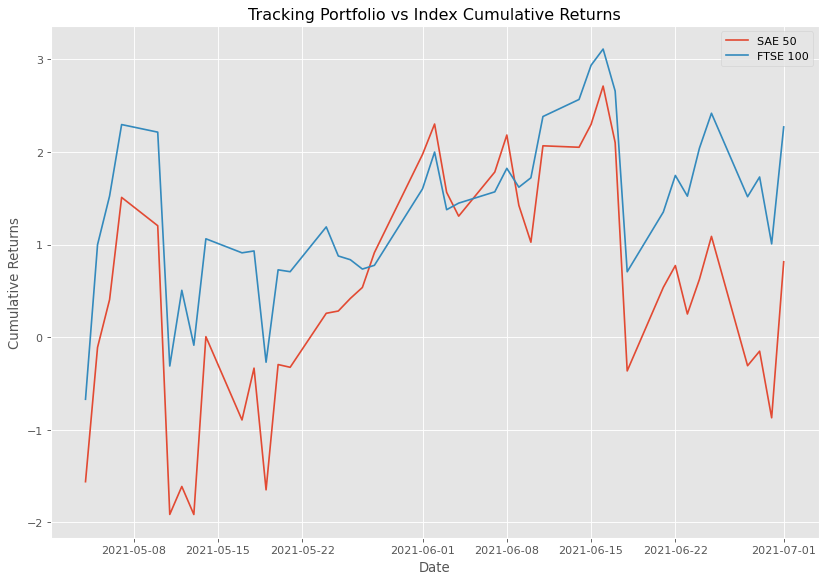

In [341]:
# Real index cumulative returns for comparison
idx_returns = pd.read_csv("../data/ftse_index_returns_2014-JUL2021.csv", index_col='Date', parse_dates=True)
daily_idx_returns = idx_returns[test_start_index:test_end_index].iloc[::-1]
idx_cum_ret = ((1+daily_idx_returns/100).cumprod()) -1


#Plot cumulative return of the constructed portfolio
# Plot
fig = plt.figure(figsize=(12, 8), dpi=80)
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(x2*100, label='SAE 50')
ax1.plot(idx_cum_ret*100, label='FTSE 100')
ax1.legend()
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Tracking Portfolio vs Index Cumulative Returns")

plt.show();

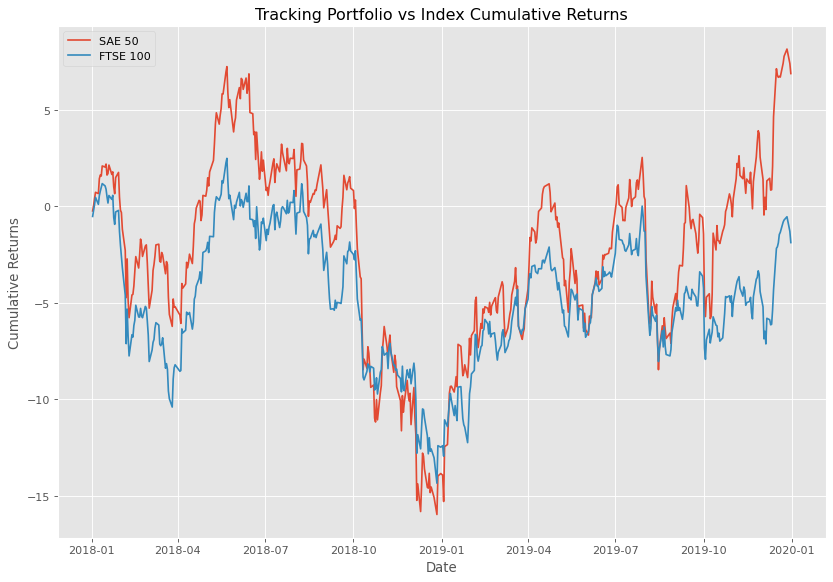

In [342]:
#Plot cumulative return of the constructed portfolio - Train Set
daily_returns_train = idx_returns[train_start_index:train_end_index].iloc[::-1]
idx_cum_ret_train = ((1+daily_returns_train/100).cumprod()) -1

# Plot
fig = plt.figure(figsize=(12, 8), dpi=80)
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(x*100, label='SAE 50')
ax1.plot(idx_cum_ret_train*100, label='FTSE 100')
ax1.legend()
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Tracking Portfolio vs Index Cumulative Returns")

plt.show();

In [343]:
# Calculating the tracking error on the test set (RMSE)
def compute_tracking_error(idx_cum_ret, tr_prt_cum_ret):
    ''' tr_prt_cum_ret: tracking portfolio cumulative returns
        idx_cum_ret: index cumulative returns
        Both sets should be of the same trading period 
    '''
    return (np.sqrt(((idx_cum_ret - tr_prt_cum_ret) ** 2).mean()))


y = (idx_cum_ret*100).to_numpy().flatten()
z = (x2*100).to_numpy().flatten()

ytr = (idx_cum_ret_train*100).to_numpy().flatten()
ztr = (x*100).to_numpy().flatten()

test = compute_tracking_error(y, z)
tr = compute_tracking_error(ytr, ztr) 
print("Testing set TE:", test)    
print("Training set TE:",tr) 

1.0868385312451443
3.3267073517217605


' after norm\n2.2011590139537596\n3.3267073517217605\n'